## Преглед на Проекта

Този ноутбук описва процеса на обучение на модел за класификация на български банкноти чрез пренос на учене с MobileNetV2. Проектът включва подготовка на данни, настройка на модела, обучение, оценка и разпространение в TensorFlow Lite.

## Импортиране на Библиотеки

За начало, импортираме необходимите библиотеки и модули за нашия проект. TensorFlow и Keras са използвани за построяване и обучение на невронната мрежа. Matplotlib се използва за визуализация на процеса на обучение. NumPy се използва за числови операции, а os за взаимодействие със файловата система.


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
import os

## Проверка за Използване на GPU

Тук се уверяваме, че сесията се изпълнява на GPU за по-бързо обучение на модела.

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro RTX 3000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5



## Подготовка на Данните и Аугментация

### Разделяне на Данните и Аугментация
Данните се разделят на обучителен и валидационен набори със съотношение 80-20. Генераторите за обучение и валидация на данни се конфигурират с размер на партидата 32 и размер на изображения 224x224.

In [3]:
# Path to dataset directory
train_dir = 'C:\\Users\\I583574\\Documents\\Uni\\Datasets\\Dataset_split_x10\\Training'
validation_dir = 'C:\\Users\\I583574\\Documents\\Uni\\Datasets\\Dataset_split_x10\\Validation'

# Image data generator with rescaling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)

# Data generators for training and validation
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # this is the input size for the mobileNetV2 network
    batch_size=32,
    class_mode='categorical',
    shuffle=True, #shuffle the order of the image that is being yielded
    seed=42, #applying random image augmentation
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True, #shuffle the order of the image that is being yielded
    seed=42, #applying random image augmentation
)

Found 26321 images belonging to 11 classes.
Found 2799 images belonging to 11 classes.


## Показване на Примери от класовете

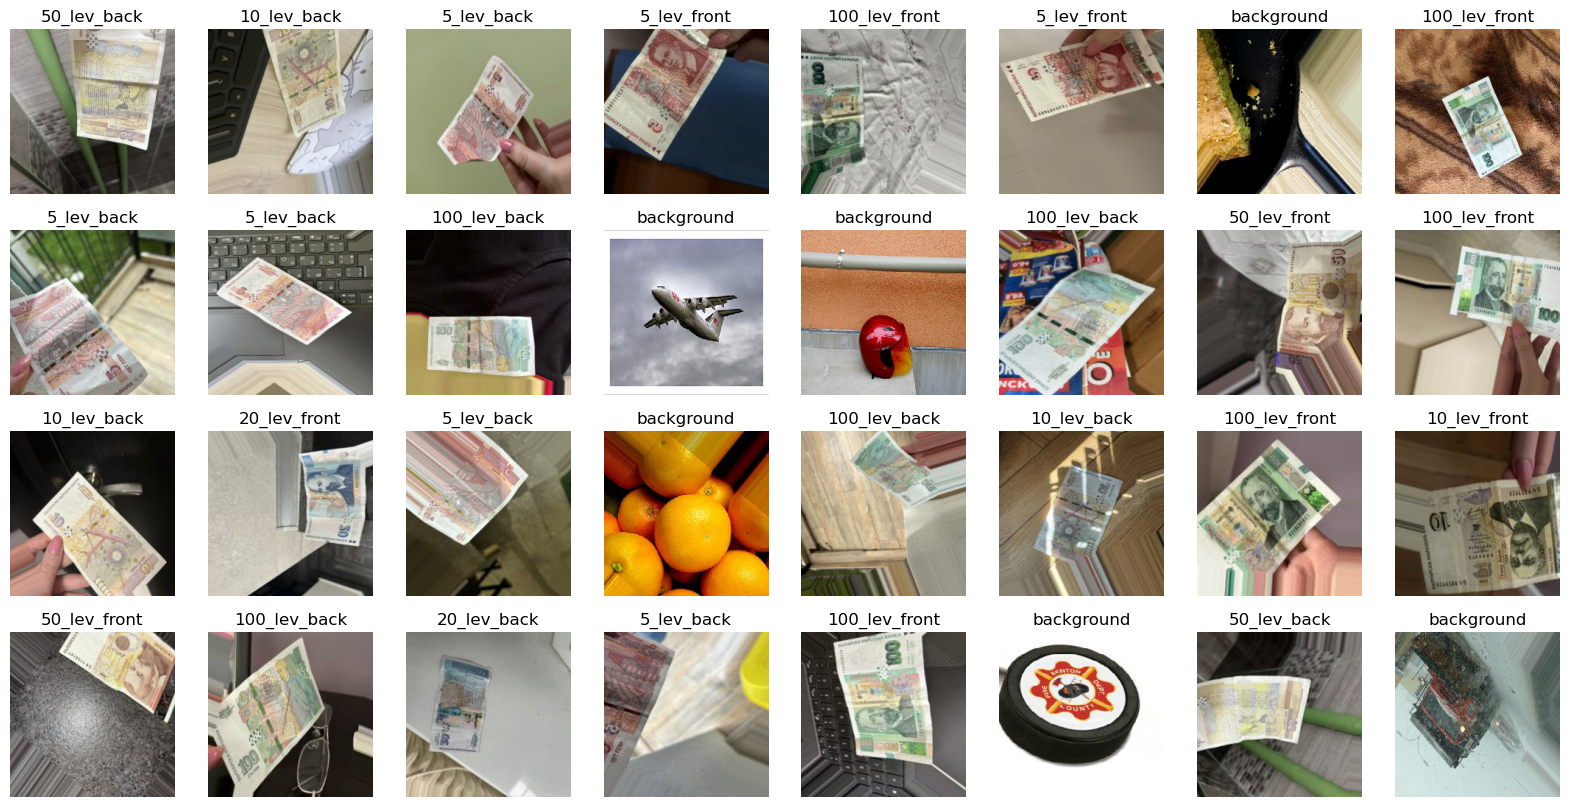

In [4]:
# Function to plot images with labels
def plot_images(images, labels, class_indices):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_idx)]
        plt.title(label)
        plt.axis('off')
    plt.show()

# Load class indices to decode labels
class_indices = train_generator.class_indices

# Retrieve images and labels from the training generator
for _ in range(len(train_generator)):
    images, labels = train_generator.next()
    plot_images(images, labels, class_indices)

    # Break if you want to only show one batch
    break

## Запазване на Файл labels
Създава се файл `labels.txt`, в който се записват сортираните имена на класовете, използвани за обучение на модела. Този файл може да се използва по-късно в приложението за класификация на банкноти.

In [5]:
import os

# Load class indices from the training generator
class_indices = train_generator.class_indices

# Sort class names by their indices
sorted_classes = sorted(class_indices, key=lambda x: class_indices[x])

# Path to save the labels.txt file
labels_file_path = 'C:\\Users\\I583574\\Documents\\Uni\\Datasets\\labels.txt'

# Write the sorted class names to the labels.txt file
with open(labels_file_path, 'w') as f:
    for class_name in sorted_classes:
        f.write(class_name + '\n')

print(f"Labels file has been saved to {labels_file_path}")

Labels file has been saved to C:\Users\I583574\Documents\Uni\Datasets\labels.txt


## Подготовка на Модела с трансферно обучение

### Зареждане на Предварително Обучен Модел

Използва се MobileNetV2, предварително обучен върху ImageNet, като базов модел за класификация на български банкноти.
Първите 96 слоя на базовия модел се замразяват, за да запазят предварително научените характеристики. Добавят се глобален слой за средно пулване, пълно свързан слой с 1024 неврона, dropout слой и финален слой за класификация. Моделът се компилира с оптимизатор Adam, учима скорост 0.00001, категориална крос-ентропийна загуба и метрики като точност, прецизност и извикване.



In [6]:
# Load the MobileNetV2 model with specific parameters
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3), alpha=1.3)

# Freeze layers up to layer n=96
for layer in base_model.layers[:96]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

callbacks = [early_stopping, lr_scheduler]

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 40  1080        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 40  160         ['Conv1[0][0]']                  
                                )                                                             

## Обучение на Модела
Моделът се обучава за 15 епохи с оптимизатор и callbacks за контрол на процеса на обучение.

In [8]:
# Model Training with Callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
822/822 [==============================] - 232s 265ms/step - loss: 0.1104 - accuracy: 0.9681 - precision: 0.9943 - recall: 0.9507 - val_loss: 0.0399 - val_accuracy: 0.9874 - val_precision: 0.9874 - val_recall: 0.9860 - lr: 1.0000e-04
Epoch 2/15
822/822 [==============================] - 343s 417ms/step - loss: 0.0043 - accuracy: 0.9990 - precision: 0.9990 - recall: 0.9987 - val_loss: 0.0025 - val_accuracy: 0.9993 - val_precision: 0.9993 - val_recall: 0.9993 - lr: 1.0000e-04
Epoch 3/15
822/822 [==============================] - 343s 417ms/step - loss: 0.0077 - accuracy: 0.9978 - precision: 0.9980 - recall: 0.9976 - val_loss: 0.0432 - val_accuracy: 0.9846 - val_precision: 0.9845 - val_recall: 0.9838 - lr: 1.0000e-04
Epoch 4/15
822/822 [==============================] - 342s 416ms/step - loss: 0.0047 - accuracy: 0.9986 - precision: 0.9987 - recall: 0.9983 - val_loss: 0.0023 - val_accuracy: 0.9989 - val_precision: 0.9993 - val_recall: 0.9986 - lr: 1.0000e-04
Epoch 5/15
822/822 [

## Оценка на модела
След обучение ние оценяваме модела, като използваме данните за валидиране, за да проверим ефективността му.

In [9]:
# Evaluate the model
loss = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)

87/87 [==============================] - 26s 297ms/step - loss: 0.0023 - accuracy: 0.9989 - precision: 0.9993 - recall: 0.9986


Оценяваме модела и с тестовите данни.

In [10]:
# Path to the test dataset
test_dir = r'C:\Users\I583574\Documents\Uni\Datasets\Test_Dataset_224'

# Initialize the ImageDataGenerator for the test set
# Image data generator with rescaling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)

# Create a test data generator
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # Typically, shuffle is set to False for the test set
)

# Evaluate the model using the test data generator
loss = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

Found 329 images belonging to 11 classes.
20/20 [==============================] - 4s 144ms/step - loss: 0.0406 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844


## Визуализиране на резултатите от обучението
Ние визуализираме резултатите от обучението, като начертаваме точността и загубата както за наборите за обучение, така и за валидиране през епохите. Това ни помага да разберем колко добре се учи моделът и дали има overfitting.

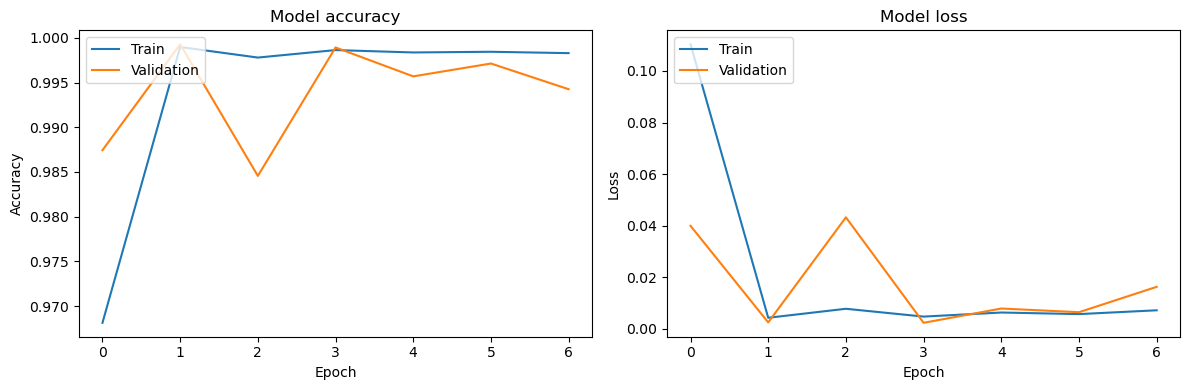

In [11]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


## Оценка с помощта на матрица на съпоставки
Този раздел оценява производителността на модела с помощта на матрица за съпоставки. Генераторът за валидиране се инициализира отново с разбъркване, зададено на False, за да поддържа реда на данните, съответстващи на labels.

Found 2799 images belonging to 11 classes.
88/88 [==============================] - 28s 314ms/step
[[199   0   0   0   0   0   0   0   0   0   0]
 [  0 202   0   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0   0]
 [  0   0   0 199   0   0   0   0   0   0   0]
 [  0   0   0   0 204   0   0   0   0   0   0]
 [  0   0   0   0   0 199   0   0   0   0   0]
 [  0   0   0   0   0   0 199   0   0   0   0]
 [  0   0   0   0   0   0   0 207   0   0   0]
 [  0   0   0   0   0   0   0   0 200   0   0]
 [  0   0   0   0   0   0   0   0   0 201   0]
 [  0   2   1   0   0   0   0   0   0   0 786]]


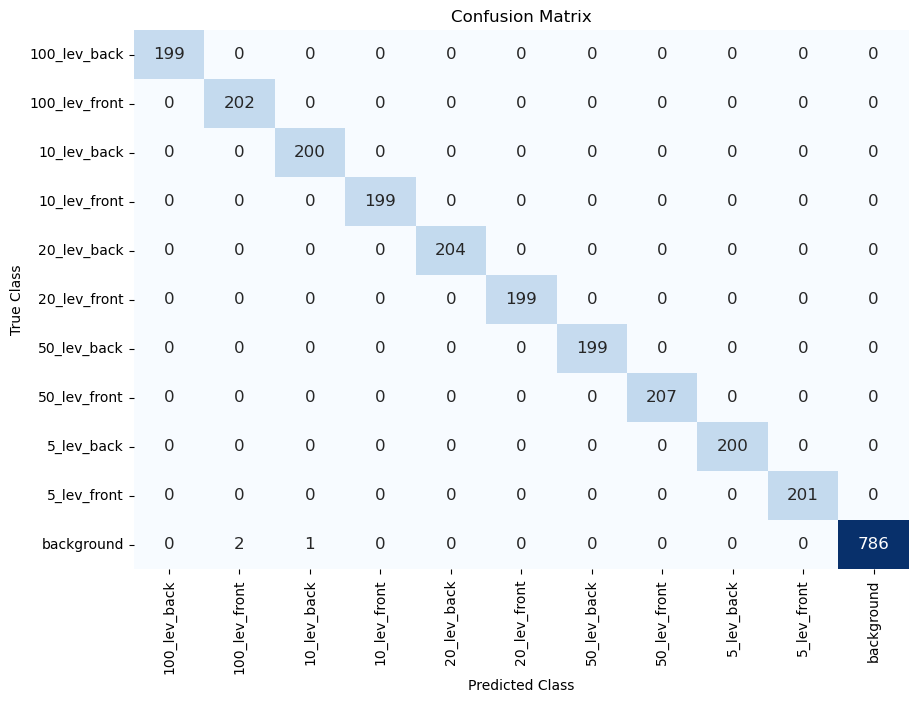

In [12]:
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Reinitialize the validation generator with shuffle set to False
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False, # shuffle=False to keep data in same order as labels
    seed=42,
)

# Get the true labels
true_classes = validation_generator.classes

# Predicted classes
predictions = model.predict(validation_generator, steps=np.ceil(validation_generator.samples / validation_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Print confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Nicer display with heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12}, 
            xticklabels=class_labels, yticklabels=class_labels)  # added xticklabels and yticklabels

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)  # optional, to prevent overlap of x-axis labels
plt.yticks(rotation=0)   # optional, to prevent overlap of y-axis labels
plt.show()

Изпринтира се и матрицата на съпоставките на тестовите данни.

Found 329 images belonging to 11 classes.
21/21 [==============================] - 4s 204ms/step
[[30  0  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  1  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0]
 [ 0  0  1  0  0  0 29  0  0  0  0]
 [ 0  1  0  0  0  0  0 28  1  0  0]
 [ 0  0  0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  1  0  0  0  0 29]]


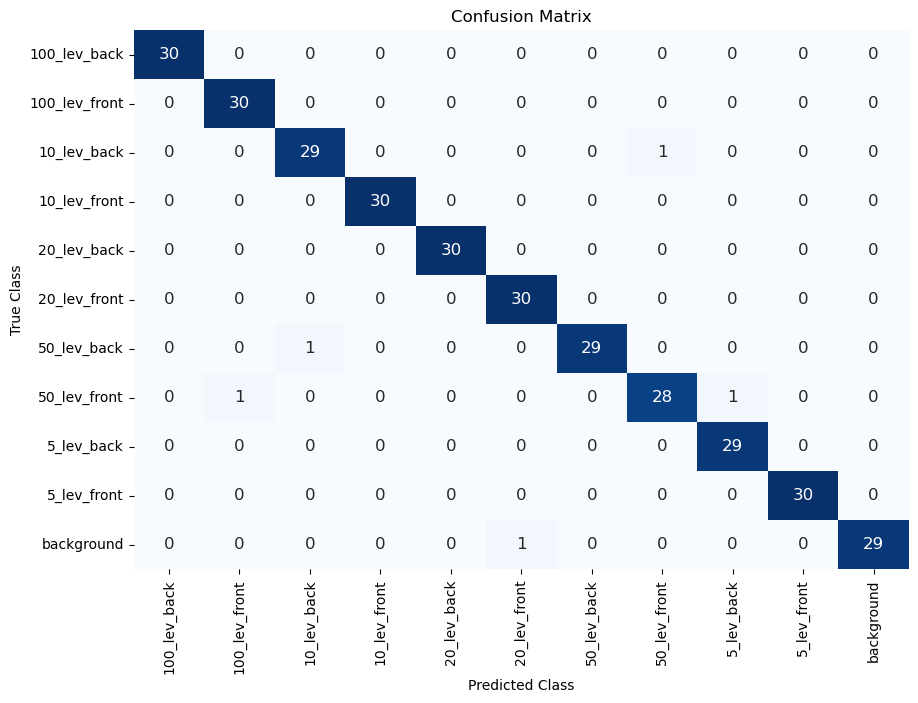

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the test dataset
test_dir = r'C:\Users\I583574\Documents\Uni\Datasets\Test_Dataset_224'

# Image data generator with rescaling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
)

# Reinitialize the test generator with shuffle set to False
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # shuffle=False to keep data in the same order as labels
)

# Get the true labels
true_classes = test_generator.classes

# Predicted classes
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Print confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Nicer display with heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12}, 
            xticklabels=class_labels, yticklabels=class_labels)  # added xticklabels and yticklabels

plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)  # optional, to prevent overlap of x-axis labels
plt.yticks(rotation=0)   # optional, to prevent overlap of y-axis labels
plt.show()

## Запазване на модела

In [14]:
# Save the model
model.save('bulgarian_banknote_classifierV1.4.h5')

In [15]:
# Load the saved model
model = tf.keras.models.load_model('bulgarian_banknote_classifierV1.4.h5')

## Инференция с Изображение Пример
В тази секция се извършва инференция върху примерно изображение, като се използва моделът за класификация. 

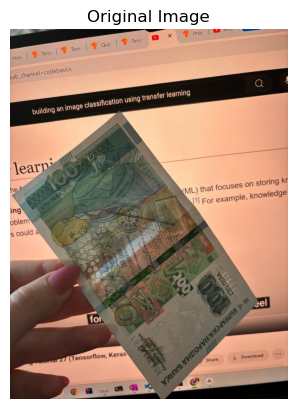

1/1 [==============================] - 2s 2s/step
Probabilities for each class:
100_lev_back: 0.9998408555984497
100_lev_front: 1.4615755272728848e-09
10_lev_back: 7.777358054108867e-16
10_lev_front: 2.5501440694374045e-13
20_lev_back: 4.1006209539062866e-10
20_lev_front: 0.00015915984113235027
50_lev_back: 2.815679479395254e-14
50_lev_front: 4.146549843395651e-15
5_lev_back: 2.930087711361124e-15
5_lev_front: 1.350160695051672e-11
background: 3.825498511716985e-12
Predicted class: 100_lev_back
Confidence: 0.99984086


In [16]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2

# Define the crop_square function
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h, w])

    # Centralize and crop
    crop_img = img[int(h / 2 - min_size / 2):int(h / 2 + min_size / 2),
                   int(w / 2 - min_size / 2):int(w / 2 + min_size / 2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized


# Load and preprocess the example image
image_path = 'C:\\Users\\I583574\\Documents\\Uni\\Testing\\IMG_8.jpeg'
image_size = (224, 224)  # Input size expected by the model

# Load the original image
image = load_img(image_path)
image_array = img_to_array(image)

# Display the original image
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')
plt.show()

# Crop and resize the image using the crop_square function
cropped_resized_img = crop_square(image_array, image_size[0])

# Normalize pixel values
cropped_resized_img = cropped_resized_img / 255.0

# Add batch dimension
cropped_resized_img = np.expand_dims(cropped_resized_img, axis=0)

# Perform inference
predictions = model.predict(cropped_resized_img)

# Print the entire vector of probabilities
print("Probabilities for each class:")
for class_index, probability in enumerate(predictions[0]):
    class_label = list(train_generator.class_indices.keys())[class_index]
    print(f"{class_label}: {probability}")

# Interpret the results
class_labels = train_generator.class_indices  # Map class indices to class labels
predicted_class = np.argmax(predictions[0])  # Get the index of the class with the highest probability
predicted_label = list(class_labels.keys())[predicted_class]  # Map index to class label
confidence = predictions[0][predicted_class]  # Get the confidence score for the predicted class

print('Predicted class:', predicted_label)
print('Confidence:', confidence)


## Конвертиране и запазване на модела в TensorFlow Lite
Конвертираме модела Keras във формат TensorFlow Lite, който е оптимизиран за внедряване на мобилни и вградени устройства.

In [17]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('bulgarian_banknote_classifierV1.4.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\I583574\AppData\Local\Temp\tmpwffmjapz\assets


INFO:tensorflow:Assets written to: C:\Users\I583574\AppData\Local\Temp\tmpwffmjapz\assets


In [18]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="bulgarian_banknote_classifierV1.4.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 224 224   3] <class 'numpy.float32'>

1 output(s):
[ 1 11] <class 'numpy.float32'>


In [19]:
keras_model_size = os.path.getsize("bulgarian_banknote_classifierV1.4.h5")/1048576 #COnvert to MB
print("Keras Model size is: ", keras_model_size, "MB")

Keras Model size is:  59.8516845703125 MB


In [20]:
tflite_model_size = os.path.getsize("bulgarian_banknote_classifierV1.4.tflite")/1048576 #Convert to MB
print("Tflite Model size is: ", tflite_model_size, "MB")

Tflite Model size is:  20.68938446044922 MB


In [21]:
# Define the directory where you want to save the model
save_directory = "C:\\Users\\I583574\\Documents\\Uni\\Models\\BanknoteNet"

# If the directory does not exist, create it
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
tflite_model = converter.convert()
tflite_model_path = os.path.join(save_directory, "bulgarian_banknote_classifierV1.4_optimized.tflite")

with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\I583574\AppData\Local\Temp\tmp9ys2hkjx\assets


INFO:tensorflow:Assets written to: C:\Users\I583574\AppData\Local\Temp\tmp9ys2hkjx\assets


In [22]:
tflite_optimized_model_size = os.path.getsize("bulgarian_banknote_classifierV1.4_optimized.tflite")/1048576 #Convert to MB
print("Tflite Optimized Model size is: ", tflite_optimized_model_size, "MB")

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'bulgarian_banknote_classifierV1.4_optimized.tflite'